In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
!pip install shapely nimfa scikit-learn seaborn

import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import shape

import importlib
from sklearn.mixture import BayesianGaussianMixture
import nimfa
import scipy
from scipy import stats
import itertools


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 45.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import datetime
#import time
#import requests
#import json
import matplotlib.pylab as plt
#from sklearn.decomposition import NMF
import numpy as np
#import itertools
import matplotlib.dates as mdates
#import nimfa
import scipy
from scipy import stats
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import matplotlib.dates as mdates

from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.neighbors import KernelDensity



def add_temp_inf(data):

    d = data.T.reset_index() # Sensors along columns and dates along rows
    c = data.index  # these are the sensors and the origin destination countries
    dictionary = dict(zip([0,1,2,3,4,5,6],["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]))
    d["new_date"] = d.date.dt.date
    d["weekday"] = d.date.dt.weekday.map(dictionary)
    d["minute"] = d.date.dt.minute
    d["hour"] = d.date.dt.hour
    d["hourminute"] = (d["hour"]*60+d["minute"])


    return d, c



def generate_trips_and_add_noise(values, repeat, samples=None, hourly = True, seed = None, hourminute = True): # add "noise" only for hourly data. Values are the hours or hourminutes and repeate are the actual number of travelers each time unit.
    if sum(repeat)>0:
        if hourminute:
            hf = 60
        else:
            hf = 1

        if seed != None:
            random.seed(seed)

        if hourly: # adds noise if hourly data
            if samples == None: #
                #single_values = np.repeat(values, repeat) + np.random.uniform(-0.5*hf, 0.5*hf, sum(repeat)) # stochastic
                single_values = np.repeat(values, repeat) + np.random.uniform(0, hf, sum(repeat)) # stochastic
                #print("len data:", len(single_values))
            else:
                #single_values = np.random.choice(np.repeat(values, repeat), samples) + np.random.uniform(-0.5*hf, 0.5*hf, samples) # stochastic
                single_values = np.random.choice(np.repeat(values, repeat), samples) + np.random.uniform(0, hf, samples) # stochastic
        else: # does not add noise if minute data
            if samples == None:
                single_values = np.repeat(values, repeat)
                #print("len data:", len(single_values))
            else:
                single_values = np.random.choice(np.repeat(values, repeat), samples) # stochastic

        return single_values
    else:
        return np.array([])


def fit_model(x, hourly_data = False, nSamp = 5000, N = 10, hourminute = True, seed = None, FitMethod = 'EM'):
    ## This is the model

    if FitMethod == 'Bayesian':
        gmm = BayesianGaussianMixture(n_components=N,
                                    random_state=42,
                                    max_iter=10000,
                                    weight_concentration_prior_type="dirichlet_distribution",
                                    covariance_type="spherical")
    elif FitMethod == 'EM':
        gmm= GaussianMixture(n_components=N,
                                  random_state=42,
                                  max_iter=10000,
                                  covariance_type="spherical")
    else:
        print('Unknown FitMethod. The code will now crash! Specify either "EM" or "Bayesian"')


    #data = np.repeat(x.index.values, x) # vector of data for a specific senor/direction, where hourminute (values from 0 to 1439) is repeated the same number of times as there are travelers that hourminute

    single_values = generate_trips_and_add_noise(x.index.values, x, samples=nSamp, hourly = hourly_data, seed = seed, hourminute = hourminute)


    ##Return fitted model
    return gmm.fit(single_values.reshape(-1, 1))


def fit_bayesian_mixtures(agg_data, start_date = None, end_date = None, hourly_data = True, nSamp = 5000, NormalizeData = False, N = 10, seed = None, FitData = True, FitMethod = 'EM'):

    if (start_date != None) | (end_date!= None):
        if start_date == None:
            start_date = agg_data.columns.min()

        if end_date == None:
            end_date = agg_data.columns.max()

        date_idx = agg_data.columns
        date_idx_new = date_idx[(date_idx >= start_date) & (date_idx <= end_date)]
        agg_data = agg_data[date_idx_new].copy() # Only keep data from start_date to end_date

    d,c = add_temp_inf(agg_data)


    if NormalizeData:
        #NORMALIZE (EVERY DAY COUNTS THE SAME)
        d[c] = d[c]/d.groupby("new_date")[c].transform("sum")*N


    data = d.groupby(["weekday", "hourminute"])[c].sum() # sums the number of travels for weekday and hourminute, for each column (which corresponds to each sensor)

    # The data frame 'data' now consists of number of travels each 'weekday' each 'hourminute'. Not other temporal info than 'hourminute' during the dat and weekday. This is the data that are used for fitting

    if FitData:
        models = data[c].reset_index("weekday").groupby("weekday").agg(lambda x : fit_model(x,hourly_data, nSamp, N = N, hourminute = True,seed = seed, FitMethod = FitMethod))
    else:
        models = None

    return models, data

def fit_period(test, d1=datetime.date(2019,1,1), d2=datetime.date(2020,1,1), hourly = True, nSamp = 5000, Normalize = False, N = 10, seed = None, FitMethod = 'EM'): # To fit for a shorter time period
    models, data = fit_bayesian_mixtures(agg_data = test[[i for i in test.columns if (i.date()<d2) & (i.date()>=d1)]], nSamp = nSamp, hourly_data = hourly, NormalizeData = Normalize, N = N, seed = seed, FitMethod = FitMethod )

    return models, data




def get_gaussian_parameters(gmm):
    '''
    Return the means of the clusters, their covariances, weights. have not ordered the components.
    '''
    n_comp = len(gmm.weights_)
    clusters = range(n_comp)
    means = gmm.means_[clusters]
    covariances = gmm.covariances_
    weights = gmm.weights_

    return means, covariances, weights



def plot_evaluation_figure(scores, d1,d2, title = '',xlim_min = datetime.date(2017,1,1), xlim_max = datetime.date(2023,12,31)):
    fig, ax = plt.subplots(1,1,figsize = (10,3),dpi=300)

    fig.suptitle(title)

    train_scores = scores[(scores.index>=d1) & (scores.index<d2)].copy().rolling(7,min_periods=0).mean() # 7 day rolling mean for each sensor.
    ax.plot(train_scores.mean(axis=1).index,train_scores.mean(axis=1).values,color="C2", label="train data")


    test_scores = scores[(scores.index<d1) | (scores.index>d2)].copy().rolling(7,min_periods=0).mean()
    test_scores.mean(axis=1).plot(ax=ax,color="C3", label="test data")

    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    # set formatter
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.legend(frameon=False, ncol=2)
    ax.set_xlabel("")
    ax.set_ylabel("daily mean log-LR")
    ax.set_xlim(xlim_min,xlim_max)



def find_possible_commuting_peaks(gauss, commuting_days, allDays = False, start_morning = 5.5, end_morning = 9, w_morning = 0.1, FINtime = False, hourminute = True ): # new updated by hilde
    # Use this in paper
    # This function only looks for a peak in the morning in a specific direction. Does not care about a returning evening peak. Does not require commuting every day

    original_sensors = gauss.columns.values
    sensors = [i[0].split(', ')[0] for i in gauss.columns.values]
    origins = [i[0].split(', ')[1] for i in gauss.columns.values]
    destinations = [i[1].split(', ')[1] for i in gauss.columns.values]

    dictionary_commuting = {}
    for sensor,o,d, original in zip(sensors,origins,destinations, original_sensors):
        # get means for commuting days for a sensor
        peaks_dir1 = gauss[(sensor + ", " + o, sensor + ", " + d)].loc[commuting_days].apply(
            lambda x: np.array(x[0]).reshape(1, -1)[0])
        # peaks_dir2 = gauss[(sensor + ", " + d, sensor + ", " + o)].loc[commuting_days].apply(
        #     lambda x: np.array(x[0]).reshape(1, -1)[0])

        # get covariance for commuting days for a sensor
        # cov_dir1 = gauss[(sensor + ", " + o, sensor + ", " + d)].loc[commuting_days].apply(
        #     lambda x: np.array(x[1]).reshape(1, -1)[0])
        # cov_dir2 = gauss[(sensor + ", " + d, sensor + ", " + o)].loc[commuting_days].apply(
        #     lambda x: np.array(x[1]).reshape(1, -1)[0])

        # get weight for commuting days for a sensor
        w_dir1 = gauss[(sensor + ", " + o, sensor + ", " + d)].loc[commuting_days].apply(
            lambda x: np.array(x[2]).reshape(1, -1)[0])
        # w_dir2 = gauss[(sensor + ", " + d, sensor + ", " + o)].loc[commuting_days].apply(
        #     lambda x: np.array(x[2]).reshape(1, -1)[0])

        if np.logical_and(o=='FIN',d=='SWE'): # This means FIN's working in Sweden and assume they follow the Swedish working hours.
            if FINtime:
                s_morning = start_morning + 1*(not hourminute )+ 60*hourminute
                e_morning = end_morning + 1*(not hourminute )+ 60*hourminute

                Morning_peak_dir1 = [np.where(np.logical_and.reduce([peaks_dir1[i] >= s_morning, w_dir1[i] >= w_morning, peaks_dir1[i] <= e_morning]))[0] for i in
                                     commuting_days] # get indices of possible commuting peaks in the morning in direction o to d
            else:
                Morning_peak_dir1 = [np.where(np.logical_and.reduce([peaks_dir1[i] >= start_morning, w_dir1[i] >= w_morning, peaks_dir1[i] <= end_morning]))[0] for i in
             commuting_days] # get indices of possible commuting peaks in the morning in direction o to d
        else:
            Morning_peak_dir1 = [np.where(np.logical_and.reduce([peaks_dir1[i] >= start_morning, w_dir1[i] >= w_morning, peaks_dir1[i] <= end_morning]))[0] for i in
             commuting_days] # get indices of possible commuting peaks in the morning in direction o to d

        #Evening_peak_dir2 = [np.where(np.logical_and.reduce([peaks_dir2[i] >= start_evening, w_dir2[i] >= w_evening, peaks_dir2[i] <= end_evening]))[0] for i in
        #     commuting_days] # get indices of possible commuting peaks in the evening in direction d to o

        #cond_pair = np.logical_and((np.array([len(p) > 0 for p in Morning_peak_dir1])),(np.array([len(p) > 0 for p in Evening_peak_dir2]))) # True when there is a peak in both directions
        if allDays: # if there has to be at least one component everyday.
            cond_morning = (np.array([len(p) > 0 for p in Morning_peak_dir1])).all() #
            if cond_morning:
                 dictionary_commuting[original] = dict(zip(commuting_days, Morning_peak_dir1))

            if ~cond_morning:
                dictionary_commuting[original] = dict(zip(commuting_days, ['NO']*len(commuting_days)))
        else:
            cond_morning = np.array([len(p) > 0 for p in Morning_peak_dir1]) #
            dictionary_commuting[original] = {}
            for i in range(len(commuting_days)): # loop over all commuting days
                if cond_morning[i]:
                    #order =np.array( mm[sensor].loc[commuting_days[i]][3]) # order of components in mm relative to the origignal models-object
                    dictionary_commuting[original][commuting_days[i]] = Morning_peak_dir1[i]

                if ~cond_morning[i]:
                    dictionary_commuting[original][commuting_days[i]] = 'NO'


    return dictionary_commuting


def find_possible_commuting_peaks_BothDirections(gauss, commuting_days, start_morning = 5.5, end_morning = 9, w_morning = 0.1, start_evening = 14, end_evening = 18, w_evening = 0.1 ): # new updated by hilde
    original_sensors = gauss.columns.values
    sensors = [i[0].split(', ')[0] for i in gauss.columns.values]
    origins = [i[0].split(', ')[1] for i in gauss.columns.values]
    destinations = [i[1].split(', ')[1] for i in gauss.columns.values]

    dictionary_morning = {}
    dictionary_evening = {} # this will contain components from the opposite direction than the sensor name!!!!!!!!!!!!!
    for sensor,o,d, original in zip(sensors,origins,destinations, original_sensors):
        # get means for commuting days for a sensor
        peaks_dir1 = gauss[(sensor + ", " + o, sensor + ", " + d)].loc[commuting_days].apply(
            lambda x: np.array(x[0]).reshape(1, -1)[0])
        peaks_dir2 = gauss[(sensor + ", " + d, sensor + ", " + o)].loc[commuting_days].apply(
            lambda x: np.array(x[0]).reshape(1, -1)[0])

        # get covariance for commuting days for a sensor
        cov_dir1 = gauss[(sensor + ", " + o, sensor + ", " + d)].loc[commuting_days].apply(
            lambda x: np.array(x[1]).reshape(1, -1)[0])
        cov_dir2 = gauss[(sensor + ", " + d, sensor + ", " + o)].loc[commuting_days].apply(
            lambda x: np.array(x[1]).reshape(1, -1)[0])

        # get weight for commuting days for a sensor
        w_dir1 = gauss[(sensor + ", " + o, sensor + ", " + d)].loc[commuting_days].apply(
            lambda x: np.array(x[2]).reshape(1, -1)[0])
        w_dir2 = gauss[(sensor + ", " + d, sensor + ", " + o)].loc[commuting_days].apply(
            lambda x: np.array(x[2]).reshape(1, -1)[0])

        Morning_peak_dir1 = [np.where(np.logical_and.reduce([peaks_dir1[i] >= start_morning, w_dir1[i] >= w_morning, peaks_dir1[i] <= end_morning]))[0] for i in
             commuting_days] # get indices of possible commuting peaks in the morning in direction o to d

        Evening_peak_dir2 = [np.where(np.logical_and.reduce([peaks_dir2[i] >= start_evening, w_dir2[i] >= w_evening, peaks_dir2[i] <= end_evening]))[0] for i in
             commuting_days] # get indices of possible commuting peaks in the evening in direction d to o

        cond_pair = np.logical_and((np.array([len(p) > 0 for p in Morning_peak_dir1])),(np.array([len(p) > 0 for p in Evening_peak_dir2]))) # True when there is a peak in both directions

        dictionary_morning[(sensor + ", " + o, sensor + ", " + d)] = {}
        dictionary_evening[(sensor + ", " + d, sensor + ", " + o)] = {}
        for i in range(len(commuting_days)): # loop over all commuting days
            if cond_pair[i]:
                #order =np.array( mm[sensor].loc[commuting_days[i]][3]) # order of components in mm relative to the origignal models-object
                dictionary_morning[(sensor + ", " + o, sensor + ", " + d)][commuting_days[i]] = Morning_peak_dir1[i]
                dictionary_evening[(sensor + ", " + d, sensor + ", " + o)][commuting_days[i]] = Evening_peak_dir2[i]

            if ~cond_pair[i]:
                dictionary_morning[(sensor + ", " + o, sensor + ", " + d)][commuting_days[i]] = 'NO'
                dictionary_evening[(sensor + ", " + d, sensor + ", " + o)][commuting_days[i]] = 'NO'


    return dictionary_morning, dictionary_evening     # returns two dictionaries: indices of morning peaks and indices of evening peaks


def estimate_number_of_commuters_over_time(agg_data, models, commuting_days, dict_commute, hourly = True, hourminute = False): # For all sensor

    def g(v): # ShortTerm
        if isinstance(v['comp'],str):
            s = 0
        else:
            s = v["total_vehicles"] * np.sum(v["p"][v["comp"]])
        return(s)


    d = agg_data.stack().reset_index(2).rename(columns= {0 : 'total_vehicles'})
    d["weekday"] = d.date.apply(lambda x: datetime.datetime.strftime(x, "%a"))

    if ~hourly:
        if hourminute:
            m = d.date.dt.minute
            h = d.date.dt.hour
            time_vec = h*60+m
            d["time"] = time_vec

        else:
           print('Hourminute variable missing')
    elif hourly:
        if hourminute:
            time_vec = d.date.dt.hour*60
            d["time"] = time_vec
        else:
            time_vec = d.date.dt.hour
            d["time"] = time_vec


    d["new_date"] = d.date.dt.date
    d["week"] = d.date.dt.isocalendar().week
    d["year"] = d.date.dt.year

    so = models.columns.get_level_values(0).values
    sd = models.columns.get_level_values(1).values
    weekdays = models.index.values

    if hourminute:
        t = np.array(range(0, 24*60)).reshape(-1,1)
    elif ~hourminute:
        t = np.array(range(0, 24)).reshape(-1,1)

    df = []

    for o, dest in zip(so,sd):
        for w in weekdays:
            df_new = pd.Series(list(models[o][dest].loc[w].predict_proba(t))).to_frame()
            df_new['time'] = t
            df_new['weekday'] = w
            df_new['sensor_origin'] = o
            df_new['sensor_destination'] = dest
            df_new['comp'] = [dict_commute[(o,dest)].get(w, 'NO')]*np.shape(t)[0]
            df.append(df_new)

    df = pd.concat(df)
    df = df.rename(columns = {0:'p'})

    d = d.reset_index().merge(df, how = 'left', on = ['sensor_origin','sensor_destination','weekday','time'] ).set_index(['sensor_origin','sensor_destination'])


    d['ShortTerm'] = d.apply(lambda x: g(x), axis=1)# finds the p for hte commuting component and multipy by all travelers. Oposite commuting direction needs to be handles separatelt below.

    if hourminute:
        d = d.rename({'time':'hourminute'})
    elif ~hourminute:
        d = d.rename({'time':'hour'})

    return d



def plot_components(sensorList, models, morning_dict, CommutingDays = ["Mon", "Tue", "Wed", "Thu", "Fri"],  ShadedArea = False, Start = None, End = None, FINtime = False, Correct_denswe = True):
    # Plot sensor components in sub figures

    n_sens = len(sensorList)

    fig = plt.figure(figsize=(10,n_sens*2.5))

    fig_list = fig.subfigures(n_sens,1)

    ax_list = list()

    for s, sensor in enumerate(sensorList):
        #def plot_components(sensor, SensorName, models_pre, models_pandemic, models_post):
        ax_list.append(fig_list[s].subplots(nrows= 1, ncols=7,sharey = 'row', sharex = 'col')) # , sharey="col"

        #topfig.subplots_adjust(hspace = 0.2, left = 0.08)
        #fig_list, ax = plt.subplots(1, 7, figsize=(10, 3), dpi=300, sharey="row",sharex = 'col')


        o = list(sensor)[0].split(', ')[1]
        d = list(sensor)[1].split(', ')[1]

        sens_name = list(sensor)[0].split(', ')[0]

        if np.logical_or(np.logical_and(o=='DEN',d=='SWE'),np.logical_and(o=='SWE',d=='DEN')):
            if Correct_denswe:
                title_str = sens_name + ', ' + d + ' -> ' + o
            else:
                title_str = sens_name + ', ' + o + ' -> ' + d
        else:
            title_str = sens_name + ', ' + o + ' -> ' + d







        fig_list[s].suptitle(title_str, y=1.05)
        fig_list[s].subplots_adjust(hspace=.2, bottom = 0.2, left = 0.08, wspace = 0.6)

        gauss_pre = models.applymap(get_gaussian_parameters)

        def plt_comps(gauss,row):
            means, covariances, weights = gauss.loc[day][sensor]
            clusters = range(10)
            order = [i[0] for i in sorted(zip(clusters, means), key=lambda x: x[1])]
            means = means[order]
            covariances = covariances[order]
            weights = weights[order]

            for m, c, w in zip(means, covariances, weights):
                xx = np.linspace(1, 24) # Evenly spaces numbers
                #xx = np.linspace(1*60, 24*60, 100*60) # Evenly spaces numbers
                ax_list[row][n].plot(xx, scipy.stats.norm.pdf(xx, m[0]/60, np.sqrt(c)/60) * w, alpha=0.8) # sample from the 10 components.

            ax_list[row][n].grid(which='both')
            #(data.loc[day][sensor] / data.loc[day][sensor].sum()).plot(ax=ax[row][n], ms=5, label="data", color="k", lw=1) # the actual data, normalized

        Start_t = Start
        End_t = End

        if ShadedArea:
            if np.logical_and(o=='FIN',d=='SWE'): # This means FIN's working in Sweden and assume they follow the Swedish working hours.
                    if FINtime:
                        Start_t = Start + 1
                        End_t = End + 1



        for n, day in enumerate(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]):

            ##ROW ONE - Prepandemic
            plt_comps(gauss_pre,s)
            #ax[0][n].set_xticks([])

            ax_list[s][n].set_xticks(range(0, 25, 6))
            ax_list[s][n].set_title(day)

            if ShadedArea:
                if np.isin(day,CommutingDays):
                    ax_list[s][n].axvspan(xmin = Start_t, xmax = End_t, fc = 'gray', alpha = 0.3)

            commute_index_morning =  morning_dict[sensor].get(day,'NO')
            if not isinstance(commute_index_morning,str):
                mu = models.loc[day][sensor].means_[commute_index_morning]
                for i in range(len(commute_index_morning)):
                    ax_list[s][n].axvline(x = mu[i][0]/60, color = 'k', lw = 1, ls = '--', label = 'Commuting component, morning')


        #ax[0][n].legend(ncol=3, frameon=False, bbox_to_anchor=(1, 1.5))

        ax_list[s][0].set_ylabel("Probability")

    #plt.show()




In [ ]:
def evaluation(d_emp , agg_data, models, base_model = 'gmm_em', eval_measure = 'LR', hourly = False, hourminute = True, d1 = None, d2 = None , seed = None ):
    # This function compares the estimated distribution (the GMM) and the daily empirical distribution of the data
    sensors = models.columns
    models = models.copy()
    agg_data = agg_data.copy()

    if np.logical_and(hourly == False,hourminute == True):
        x =  list(range(0,60*24))

    if np.logical_and(hourly == True,hourminute == True):
        x =  list(range(0,60*24,60))

    if hourminute:
        hf = 60
    else:
        hf = 1


    d,c = add_temp_inf(agg_data) # agg_data is transposed and time is added
    #d[sensors] = d[sensors].astype('int64')
    #sum_df = d.groupby('new_date')[sensors].sum()

    #d = d.set_index('new_date')

    #d[sensors] = d[sensors].div(sum_df) # This is the empirical distribution for each day, for each sensor.
    # Empirical probability distribution each day for each sensor
    n_df = pd.DataFrame(columns = sensors, index = d.new_date.unique()[:-1])
    dd = d.copy().sort_values(by = 'hourminute').groupby('new_date')[sensors].apply(lambda x: tuple(np.transpose(x.values)))
    for date in n_df.index:
        for i, s in enumerate(sensors):
            n_df.loc[date,s] = dd[date][i]

    n_df = n_df.reset_index().drop(axis = 0,labels=0).rename(columns = {'index':'date'}).set_index('date')

    #d_emp = pd.DataFrame(columns = n_df.columns, index = n_df.index)
        # #for date in d.new_date.unique():
        #     d_new.loc[date,s] = d[d['new_date'] == date].sort_values(by = 'hourminute')[s].values

    def dens_func(x, n, model, hourly=False):
      n_int = np.array(n, dtype=int)

      if hourly:
          data_vec = np.repeat(x, n_int) + np.random.uniform(0, hf, sum(n_int))
      else:
          data_vec = np.repeat(x, n_int)

      if sum(n_int) < 50:
          dens = float('nan')
      else:
          ncomp = min(sum(n_int), 10)
          if model == 'gmm_bayesian':
              dens = BayesianGaussianMixture(
                  n_components=ncomp,
                  random_state=42,
                  max_iter=10000,
                  weight_concentration_prior_type="dirichlet_distribution",
                  covariance_type="spherical"
              ).fit(data_vec.reshape(-1, 1)).score_samples(np.array(x).reshape(-1, 1))
          elif model == 'gmm_em':
              dens = GaussianMixture(
                  n_components=ncomp,
                  random_state=42,
                  max_iter=10000,
                  covariance_type="spherical"
              ).fit(data_vec.reshape(-1, 1)).score_samples(np.array(x).reshape(-1, 1))
          elif model == 'kernel':
              dens = KernelDensity(kernel='gaussian').fit(
                  data_vec.reshape(-1, 1)).score_samples(np.array(x).reshape(-1, 1))
          elif model == 'empirical':
              dens = n_int / sum(n_int)

      return dens


    #d_emp = d_emp.applymap(dens_func, model = base_model).reset_index().rename(columns={'index': 'date'}).drop(axis=0,index = 0)


    # Probability distribution for each weekday for each sensor from gmm.
    gmm_df = pd.DataFrame(columns=sensors, index = ['Mon','Tue','Wed','Thu','Fri','Sun','Sat']) # These are the gmm-probabilities
    for s in gmm_df.columns:
        for day in ['Mon','Tue','Wed','Thu','Fri','Sun','Sat']:
            prop = models[s][day].score_samples(np.array(x).reshape(-1,1)) # ln
            gmm_df.loc[day, s] = prop


    if eval_measure == 'LR':
        def lr_func(emp,gmm,n):
            l_gmm = sum(gmm*n) # ln
            l_emp = sum(emp*n) # ln

            lr = l_gmm-l_emp
            return(lr)

        df_eval = pd.DataFrame(columns = sensors, index = d_emp.index)
        for dt in df_eval.index:
            for s in sensors:
                df_eval.loc[dt,s] = lr_func(emp = d_emp.loc[dt,s],gmm = gmm_df.loc[d_emp.loc[dt,'weekday'].values[0],s], n = n_df.loc[dt,s]) # input needs to be ln
                #df = d_emp[[s,('date',''),('weekday','')]].rename(columns={s[0]:'s_emp'}, level=0).droplevel(level = 1, axis=1).merge(gmm_df[[s,('weekday','')]].rename(columns={s[0]:'s_gmm'}, level=0).droplevel(level = 1, axis=1), on='weekday')

    elif eval_measure == 'KL':
        df_eval = pd.DataFrame(columns = sensors, index = d_emp.index)
        for dt in df_eval.index:
            for s in sensors:
                df_eval.loc[dt,s] = stats.entropy(pk = np.exp(d_emp.loc[dt,s]), qk = np.exp(gmm_df.loc[d_emp.loc[dt,'weekday'].values[0],s] ))


    return df_eval


In [ ]:
import pandas as pd

agg_data_fin = pd.read_pickle('/content/drive/MyDrive/STAGE ING-2025/Data/FinSwe_GMM/agg_data_fin.pkl')
models_fin = pd.read_pickle('/content/drive/MyDrive/STAGE ING-2025/Data/FinSwe_GMM/models_fin.pkl')
emp_fin_gmm=pd.read_pickle('/content/drive/MyDrive/STAGE ING-2025/Data/emp_fin_gmm_bayesian_KL_final.pkl')
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/STAGE ING-2025/Data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Copie de utils.py'		        eval_fin_gmm_bayesian_KL_test_t.pkl
 Data				        eval_nor_gmm_all.pkl
 Data-visualisation.ipynb	        eval_nor_gmm_bayesian_KL_final.pkl
 DenSwe_GMM			        eval_nor_gmm_bayesian_KL.pkl
 emp_den_gmm_bayesian_KL_final.pkl      evaluation_fin.ipynb
 emp_fin_gmm_bayesian_KL_final.pkl      FIN-SWE
 emp_fin_gmm_bayesian_KL_test.pkl       FinSwe-data-visualisation.ipynb
 emp_fin_gmm_bayesian_KL_test_t1.pkl    FinSwe_GMM
 emp_fin_gmm_bayesian_KL_test_t.pkl     NorSwe
 emp_nor_gmm_bayesian_KL_final.pkl      NorSwe_GMM
 emp_nor_gmm_bayesian_KL.pkl	        __pycache__
 eval_den_gmm_bayesian_KL_final.pkl     Untitled
 eval_fin_gmm_bayesian_KL_final.pkl     Untitled0.ipynb
 eval_fin_gmm_bayesian_KL_test.pkl      Untitled1.ipynb
 eval_fin_gmm_bayesian_KL_test_t1.pkl   utils.py


In [ ]:
# Only keep sensor columns (tuples), drop metadata like 'weekday'
sensor_columns = [col for col in emp_fin_gmm.columns if isinstance(col, tuple)]
emp_fin_gmm = emp_fin_gmm[sensor_columns]
lr = evaluation(
    d_emp=emp_fin_gmm,
    agg_data=agg_data_fin,
    models=models_fin,
    d1=datetime.datetime(2017, 1, 1),
    d2=datetime.datetime(2020, 3, 1),
    base_model='gmm_bayesian',
    eval_measure='LR',
    hourly=False,
    hourminute=True
)


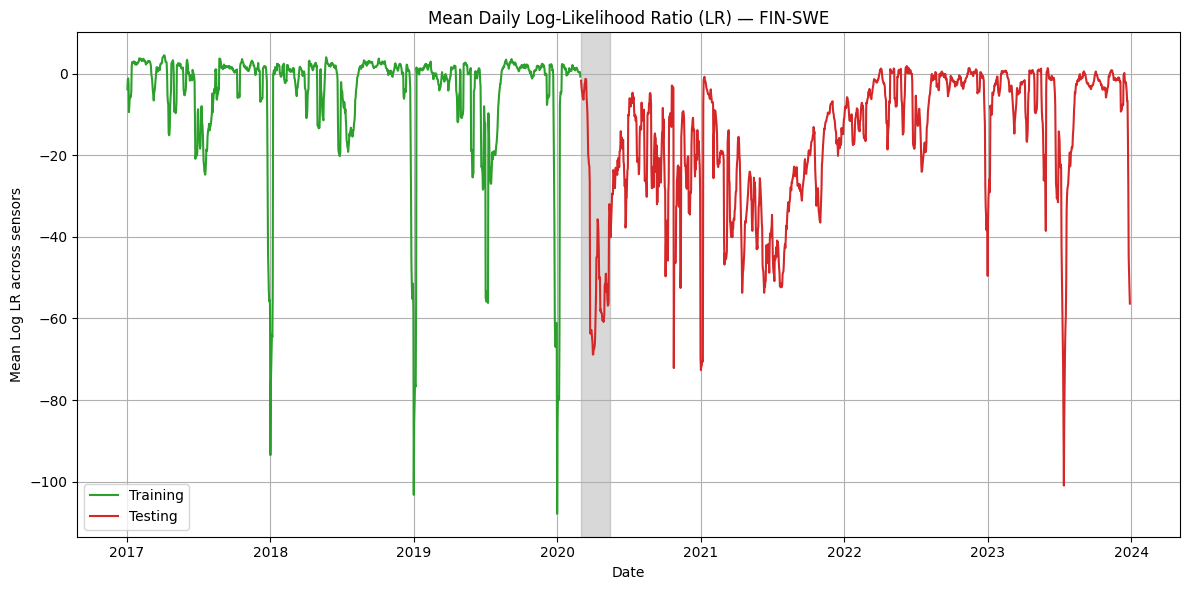

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Ensure datetime index
lr.index = pd.to_datetime(lr.index)

# Define training period boundaries
d1 = datetime.datetime(2017, 1, 1)
d2 = datetime.datetime(2020, 3, 1)

# Compute 7-day rolling mean of LR across all sensors
lr_rolling_mean = lr.rolling(window=7, min_periods=1).mean()
lr_mean = lr_rolling_mean.mean(axis=1)

# Split into train and test sets
train_mean = lr_mean[(lr_mean.index >= d1) & (lr_mean.index < d2)]
test_mean = lr_mean[(lr_mean.index < d1) | (lr_mean.index > d2)]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_mean.index, train_mean.values, label='Training', color='C2')
plt.plot(test_mean.index, test_mean.values, label='Testing', color='C3')

# Highlight pandemic period (optional)
plt.axvspan(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 5, 15), color='gray', alpha=0.3)

plt.title('Mean Daily Log-Likelihood Ratio (LR) — FIN-SWE')
plt.xlabel('Date')
plt.ylabel('Mean Log LR across sensors')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import datetime

# ---- Assumes you already have `lr` as a DataFrame with datetime index ----
# 1) Ensure datetime index
lr = lr.copy()
lr.index = pd.to_datetime(lr.index)

# 2) Rolling mean per sensor, then mean across sensors
lr_rolling_mean = lr.rolling(window=7, min_periods=1).mean()
lr_mean = lr_rolling_mean.mean(axis=1)

# 3) Train/test windows (same as your plotting cell)
d1 = datetime.datetime(2017, 1, 1)
d2 = datetime.datetime(2020, 3, 1)

def split_train_test(series):
    train = series[(series.index >= d1) & (series.index < d2)]
    test  = series[(series.index < d1) | (series.index > d2)]
    return train, test

# 4) Metric helpers vs. zero (since LLR is already a residual-like statistic)
def metrics_vs_zero(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna().values.astype(float)
    if x.size == 0:
        return {"count": 0, "MSE": np.nan, "RMSE": np.nan, "MAE": np.nan}
    mse  = float(np.mean(x**2))
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(x)))
    return {"count": int(x.size), "MSE": mse, "RMSE": rmse, "MAE": mae}

# 5) Per-sensor metrics (after rolling mean)
rows = []
for col in lr_rolling_mean.columns:
    s = lr_rolling_mean[col].dropna()
    tr, te = split_train_test(s)
    rows.append({
        "series": f"sensor:{col}",
        **{f"train_{k}": v for k, v in metrics_vs_zero(tr).items()},
        **{f"test_{k}": v for k, v in metrics_vs_zero(te).items()},
        **{f"all_{k}": v for k, v in metrics_vs_zero(s).items()},
    })

# 6) All-sensor mean series metrics
tr_mean, te_mean = split_train_test(lr_mean)
rows.append({
    "series": "mean_across_sensors",
    **{f"train_{k}": v for k, v in metrics_vs_zero(tr_mean).items()},
    **{f"test_{k}": v for k, v in metrics_vs_zero(te_mean).items()},
    **{f"all_{k}": v for k, v in metrics_vs_zero(lr_mean).items()},
})

llr_metric_table = pd.DataFrame(rows).sort_values("series").reset_index(drop=True)
print(llr_metric_table.to_string(index=False))


                           series  train_count   train_MSE  train_RMSE  train_MAE  test_count     test_MSE  test_RMSE  test_MAE  all_count      all_MSE   all_RMSE   all_MAE
              mean_across_sensors         1154  227.285926   15.076005   6.626092        1398   568.379210  23.840705 16.783289       2553   413.976553  20.346414 12.185570
sensor:('1431, FIN', '1431, SWE')         1154 3056.644665   55.286930  23.668904        1398  1794.070731  42.356472 28.673347       2553  2364.092333  48.621933 26.402761
sensor:('1431, SWE', '1431, FIN')         1154 3935.461436   62.733256  25.992035        1336 21829.439197 147.747891 96.044791       2491 13531.023159 116.322926 63.557546
sensor:('1432, FIN', '1432, SWE')         1154  262.161753   16.191410  10.357666        1398    96.664795   9.831826  6.195221       2553   171.459349  13.094249  8.077417
sensor:('1432, SWE', '1432, FIN')         1154  237.153716   15.399796   8.328551        1398    87.175264   9.336769  5.563544       2

In [ ]:
import numpy as np

# Flatten all sensors’ LLR values into one big array
llr_vals = lr.dropna(how="any").values.flatten().astype(float)

mse  = np.mean(llr_vals**2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(llr_vals))

print(f"Overall MSE (LLR vs 0):  {mse:.6f}")
print(f"Overall RMSE (LLR vs 0): {rmse:.6f}")
print(f"Overall MAE  (LLR vs 0): {mae:.6f}")


Overall MSE (LLR vs 0):  1919.186235
Overall RMSE (LLR vs 0): 43.808518
Overall MAE  (LLR vs 0): 11.153388
